## import

In [47]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data Load

In [49]:
# 파일 호출
data_path = "../data"
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_submission = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

# sub data
interestrate_df = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
park_df = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))
school_df = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
subway_df = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))

## feature extraction

#### park, school, subway

In [50]:
places_dict = {'park':park_df, 'school':school_df, 'subway':subway_df}
radii_dict = {
    'park': [500, 1000, 1500, 2000],
    'school': [100, 200, 300, 400, 500, 1000, 1500, 2000],
    'subway': [300, 500, 800, 1000, 1500, 2000]
}

In [51]:
from sklearn.neighbors import BallTree

# 위경도를 라디안으로 변환
def to_radians(df, lat_col='latitude', lon_col='longitude'):
    df['latitude_radi'] = np.radians(df[lat_col])
    df['longitude_radi'] = np.radians(df[lon_col])
    return df

In [52]:
def count_places(main_df, places_dict, radii_dict):
    """
    main_df: 원본 데이터 (계산 대상 위치)
    places_dict: 장소 데이터 딕셔너리, {장소 이름: 장소 데이터프레임}
    radii_dict: 반경 리스트 딕셔너리, {장소 이름: 반경 리스트(예: [300, 500, 1000])}
    """
    
    # 위경도를 라디안으로 변환 (main_df에 적용)
    main_df = to_radians(main_df)

    # 각 장소 유형별로 BallTree를 생성하여 반경 내 개수를 계산
    for place_name, add_df in places_dict.items():

        # 각 장소 데이터의 위경도를 라디안으로 변환
        add_df = to_radians(add_df)

        # 장소 데이터에 대해 BallTree 생성
        ball_tree = BallTree(add_df[['latitude_radi', 'longitude_radi']].values, metric='haversine')

        for radius in radii_dict[place_name]:
            # 반경을 km로 변환
            radius_in_km = radius / 1000

            # 반경 내 place 개수 계산(반경을 지구 반지름(6371km)로 나눈 값)
            _, indices = ball_tree.query_radius(main_df[['latitude_radi', 'longitude_radi']].values, r=radius_in_km/6371, return_distance=True)

            # 반경별 장소 개수 열 추가
            main_df[f'{place_name}_{radius}m'] = [len(idx) for idx in indices]
        
        distances, distances_index = ball_tree.query(main_df[['latitude_radi', 'longitude_radi']].values, k=1)
        main_df[f'{place_name}_near_distance'] = distances.flatten()*6371

        # 공원: area 추가
        if place_name == 'park':
            main_df['park_near_area'] = add_df.iloc[distances_index.flatten(), 2].reset_index(drop=True)

    return main_df

In [53]:
train_df = count_places(train_df, places_dict, radii_dict)
train_df.to_csv("train_df_seperate.csv")
test_df = count_places(test_df, places_dict, radii_dict)
test_df.to_csv("test_df_seperate.csv")

## feature selection

In [54]:
train_df['age'] = train_df['age'].clip(lower=0)

age_mapping = {'0-10': 0, '10-20': 10, '20-30': 20, '30+': 30}
train_df['age_group'] = pd.cut(train_df['age'], bins=[0, 10, 20, 30, 300], labels=[0, 10, 20, 30], right=False)
train_df['age_group'] = train_df['age_group'].astype(int)
test_df['age_group'] = pd.cut(test_df['age'], bins=[0, 10, 20, 30, 300], labels=[0, 10, 20, 30], right=False)
test_df['age_group'] = test_df['age_group'].astype(int)

In [55]:
train_df = train_df.drop(columns=['index', 'contract_day', 'age'])
test_df = test_df.drop(columns=['index', 'contract_day', 'age'])

In [56]:
train_df['contract_type'] = train_df['contract_type'].replace(2, np.nan)
test_df['contract_type'] = test_df['contract_type'].replace(2, np.nan)

### add feature : deposit per area

In [57]:
train_df['deposit_per_area'] = train_df['deposit'] / train_df['area_m2']

In [58]:
train_df.drop(columns=['deposit'], inplace=True)

## train, valid split

In [59]:
holdout_start = 202307
holdout_end = 202312
valid_df = train_df[(train_df['contract_year_month'] >= holdout_start) & (train_df['contract_year_month'] <= holdout_end)]
final_train_df = train_df[~((train_df['contract_year_month'] >= holdout_start) & (train_df['contract_year_month'] <= holdout_end))]

## X, y split

In [60]:
X_train = final_train_df.drop(columns=['deposit_per_area'])
y_train = final_train_df['deposit_per_area']
X_valid = valid_df.drop(columns=['deposit_per_area'])
y_valid = valid_df['deposit_per_area']
X_test = test_df.copy()

X_total = train_df.drop(columns=['deposit_per_area'])
y_total = train_df['deposit_per_area']

## Custom Loss

In [61]:
class AsymmetricHuberLoss:
    def __init__(self, delta=1.0, beta=1.05):   # 작게 예측하는 값에 대해 loss를 키운다.(default : 5%)
        self.delta = delta
        self.beta = beta

    def _calculate_loss(self, y_true, y_pred):

        # 식 구현
        error = y_true - y_pred
        abs_error = np.abs(error) / y_true
        quadratic = np.minimum(abs_error, self.delta)   
        linear = abs_error - quadratic 
        loss = 0.5 * quadratic**2 + self.delta * linear

        # loss penalty 추가
        underestimation_mask = y_pred < y_true * 0.95 
        loss[underestimation_mask] *= self.beta
        return loss   # eval_metric에 사용

    def gradient(self, y_true, y_pred):   # 1차 미분값
        error = y_pred - y_true
        abs_error = np.abs(error) / y_true
        grad = np.where(abs_error <= self.delta, error, self.delta * np.sign(error))  
        grad[y_pred < y_true * 0.95] *= self.beta   
        return grad

    def hessian(self, y_true, y_pred):   # 2차 미분값
        abs_error = np.abs(y_pred - y_true) / y_true
        hess = np.where(abs_error <= self.delta, 1.0, 0.0)
        hess[y_pred < y_true * 0.95] *= self.beta   
        return hess

def custom_loss(y_true, y_pred):
    loss = AsymmetricHuberLoss()
    grad = loss.gradient(y_true, y_pred)
    hess = loss.hessian(y_true, y_pred)
    return grad, hess

def custom_metric(y_pred, y_true):
    loss = AsymmetricHuberLoss()
    return np.mean(loss._calculate_loss(y_true, y_pred)) * 1000

## 군집화

In [62]:
from sklearn.cluster import KMeans

In [63]:
# train + valid 데이터로 최적의 k 찾기
best_k = 10
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_SEED)
kmeans.fit(X_total[['latitude', 'longitude']])
total_pred = kmeans.predict(X_total[['latitude', 'longitude']])

/opt/conda/envs/house/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [64]:
total_pred

array([4, 4, 4, ..., 5, 5, 5], dtype=int32)

In [65]:
# test 데이터에 대한 cluster 예측
test_pred = kmeans.predict(X_test[['latitude', 'longitude']])

## 모델링

#### xgboost

In [66]:
xgb_models = []
best_iterations = []
train_pred = kmeans.predict(X_train[['latitude', 'longitude']])
valid_pred = kmeans.predict(X_valid[['latitude', 'longitude']])
X_train = X_train.drop(columns=['latitude', 'longitude'])
X_valid = X_valid.drop(columns=['latitude', 'longitude'])

In [67]:
for i in range(best_k):
    print(f'Cluster {i} modeling...')
    train_cluster_idx = np.where(train_pred == i)[0]   # (index_array, dtype)
    valid_cluster_idx = np.where(valid_pred == i)[0]

    X_train_cluster = X_train.iloc[train_cluster_idx]
    y_train_cluster = y_train.iloc[train_cluster_idx]

    X_valid_cluster = X_valid.iloc[valid_cluster_idx]
    y_valid_cluster = y_valid.iloc[valid_cluster_idx]

    xgb_params = {
        'objective': custom_loss,   # default : reg:squarederror
        'eval_metric': custom_metric,   # default : rmse
        'seed': RANDOM_SEED,
        'n_estimators': 500,
        'learning_rate': 0.02,   # default : 0.3
        'max_depth': 12,
        # 'subsample': 0.9,
        # 'colsample_bytree': 0.9,
        # 'reg_alpha': 10.0,
        # 'reg_lambda': 10.0,
        'early_stopping_rounds':20,
        'n_jobs': -1,
        'device': 'cuda'
    }

    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X_train_cluster, y_train_cluster, eval_set=[(X_valid_cluster, y_valid_cluster)], verbose=50)
    best_iterations.append(xgb_model.best_iteration)

    xgb_models.append(xgb_model)

Cluster 0 modeling...
[0]	validation_0-rmse:531.20664	validation_0-custom_metric:48711.97510
[50]	validation_0-rmse:225.84824	validation_0-custom_metric:233.99897
[100]	validation_0-rmse:121.56335	validation_0-custom_metric:37.92604
[150]	validation_0-rmse:90.10722	validation_0-custom_metric:18.14383
[200]	validation_0-rmse:81.33075	validation_0-custom_metric:14.29555
[250]	validation_0-rmse:78.64609	validation_0-custom_metric:13.21322
[300]	validation_0-rmse:77.76128	validation_0-custom_metric:12.82031
[350]	validation_0-rmse:77.53093	validation_0-custom_metric:12.79598
[356]	validation_0-rmse:77.53120	validation_0-custom_metric:12.80006
Cluster 1 modeling...
[0]	validation_0-rmse:518.59230	validation_0-custom_metric:49520.90836
[50]	validation_0-rmse:221.04751	validation_0-custom_metric:249.20748
[100]	validation_0-rmse:117.86436	validation_0-custom_metric:39.99010
[150]	validation_0-rmse:84.69224	validation_0-custom_metric:18.26636
[200]	validation_0-rmse:74.54836	validation_0-custo

<Figure size 1000x800 with 0 Axes>

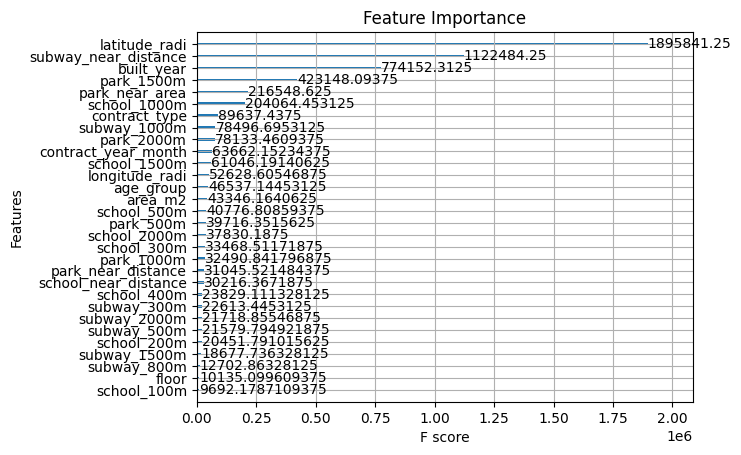

<Figure size 1000x800 with 0 Axes>

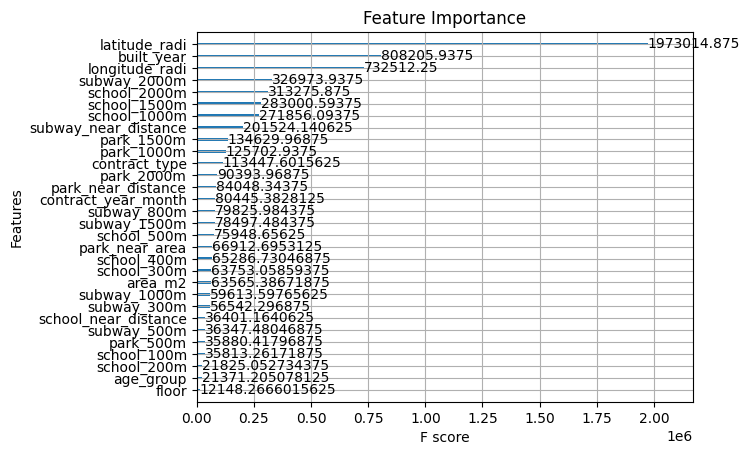

<Figure size 1000x800 with 0 Axes>

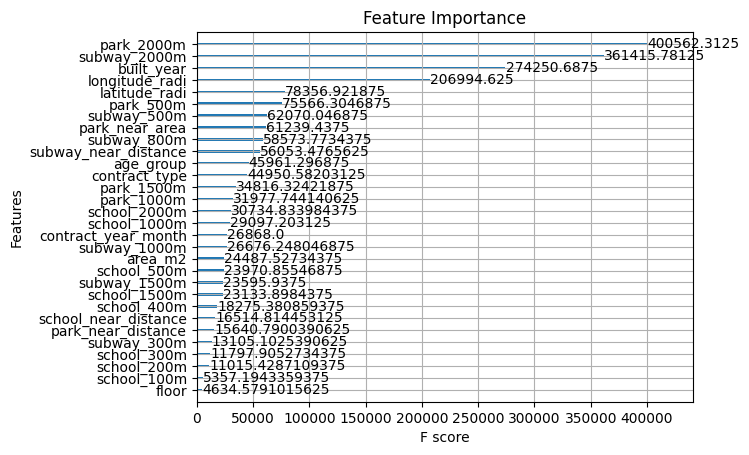

<Figure size 1000x800 with 0 Axes>

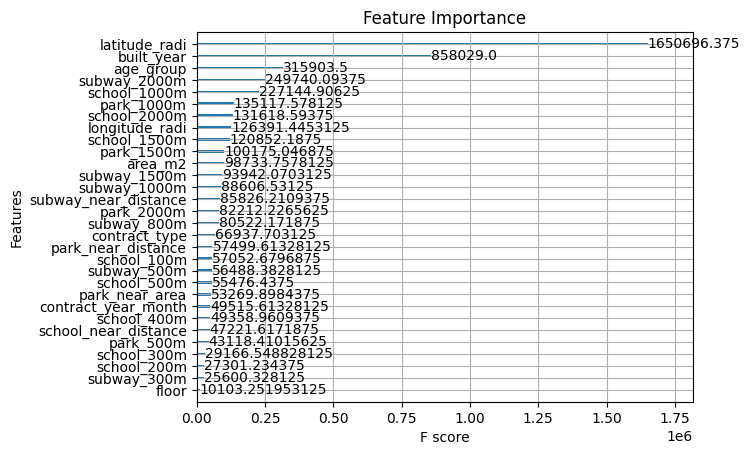

<Figure size 1000x800 with 0 Axes>

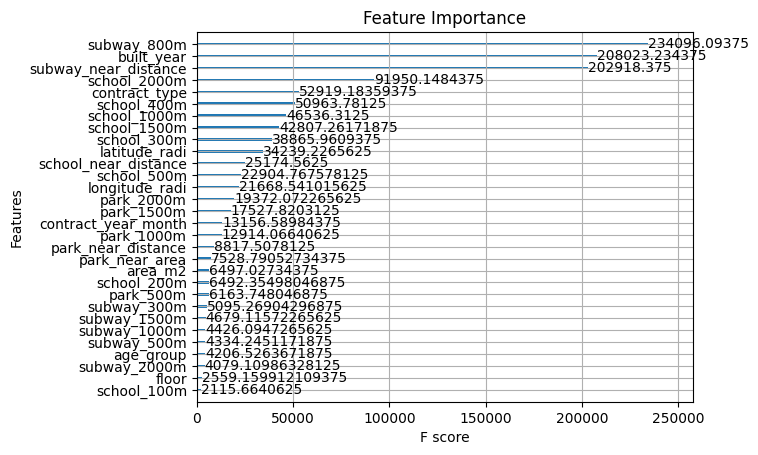

<Figure size 1000x800 with 0 Axes>

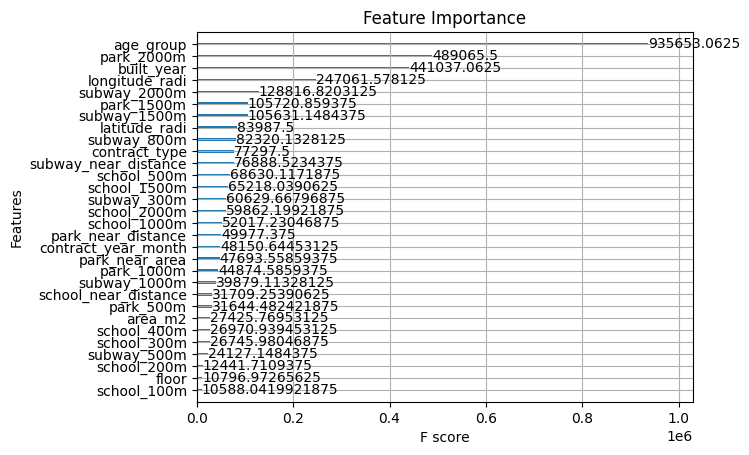

<Figure size 1000x800 with 0 Axes>

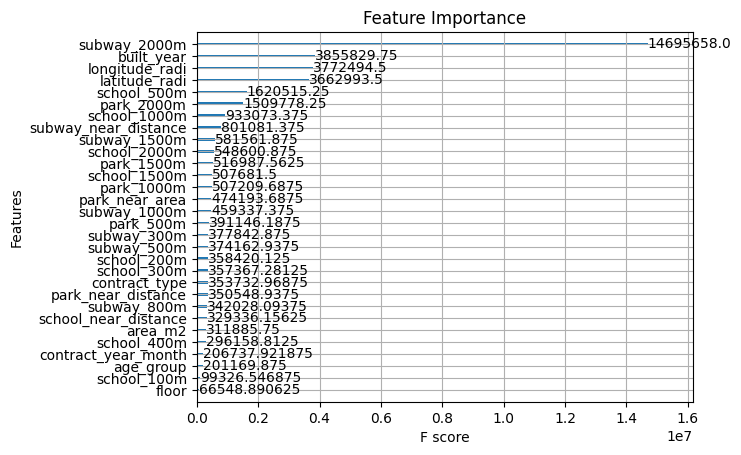

<Figure size 1000x800 with 0 Axes>

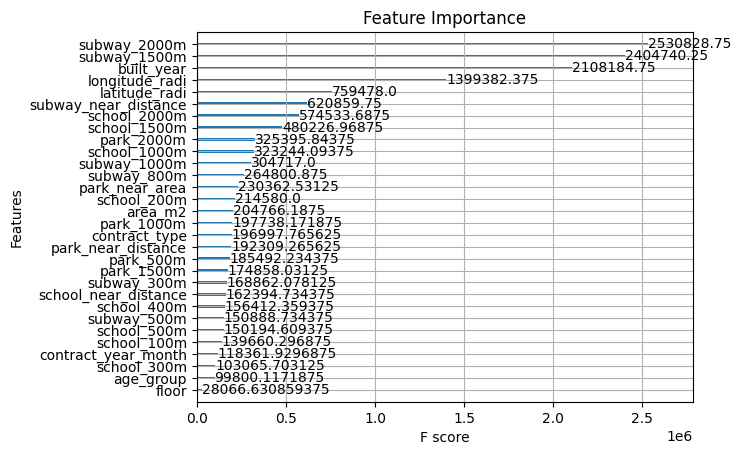

<Figure size 1000x800 with 0 Axes>

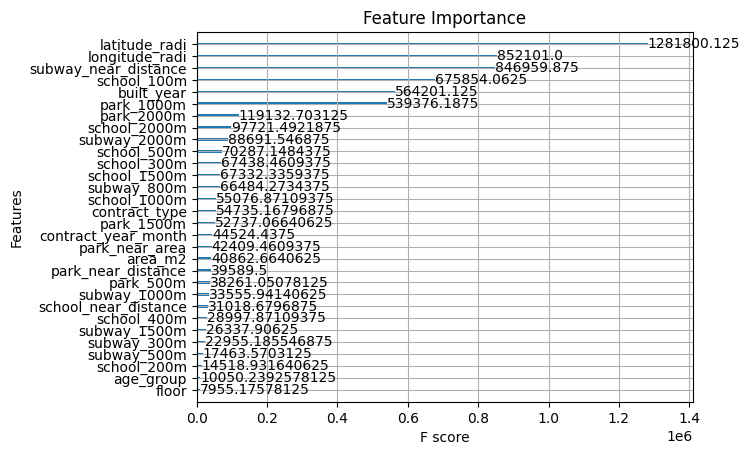

<Figure size 1000x800 with 0 Axes>

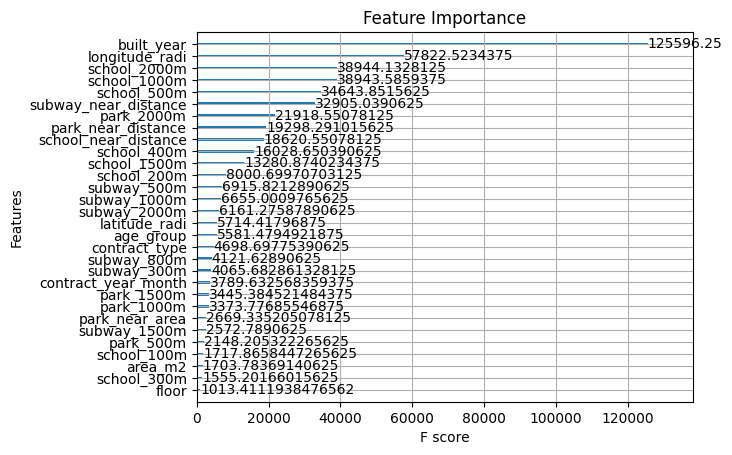

In [68]:
for xgb_model in xgb_models:
    plt.figure(figsize=(10, 8))
    plot_importance(xgb_model, importance_type='gain')  # max_num_features로 출력할 feature 개수 지정 가능
    plt.title('Feature Importance')
    plt.show()

## valid 성능

In [69]:
X_valid['pred'] = 0
for i in range(best_k):
    valid_cluster_idx = np.where(valid_pred == i)[0]
    X_valid_cluster = X_valid.iloc[valid_cluster_idx]
    X_valid.loc[X_valid_cluster.index, 'pred'] = xgb_models[i].predict(X_valid_cluster.drop(columns=['pred']))

valid_pred = X_valid['pred']
valid_mae = mean_absolute_error(y_valid, valid_pred)

print(valid_mae)

54.86705713494375


## 최종 학습

In [70]:
xgb_models = []
total_pred = kmeans.predict(X_total[['latitude', 'longitude']])
X_total = X_total.drop(columns=['latitude', 'longitude'])
for i in range(best_k):
    print(f'Cluster {i} modeling...')
    total_cluster_idx = np.where(total_pred == i)[0]   # (index_array, dtype)

    X_total_cluster = X_total.iloc[total_cluster_idx]
    y_total_cluster = y_total.iloc[total_cluster_idx]

    xgb_params = {
        'objective': custom_loss,
        'eval_metric': custom_metric,
        'seed': RANDOM_SEED,
        'n_estimators': round(best_iterations[i], -1),   # 1의 자리에서 반올림
        'learning_rate': 0.02,   # default : 0.3
        'max_depth': 12,
        # 'subsample': 0.9,
        # 'colsample_bytree': 0.9,
        # 'reg_alpha': 10.0,
        # 'reg_lambda': 10.0,
        # 'early_stopping_rounds':20,
        'n_jobs': -1,
        'device': 'cuda'
    }

    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X_total_cluster, y_total_cluster, verbose=20)

    xgb_models.append(xgb_model)

Cluster 0 modeling...
Cluster 1 modeling...
Cluster 2 modeling...
Cluster 3 modeling...
Cluster 4 modeling...
Cluster 5 modeling...
Cluster 6 modeling...
Cluster 7 modeling...
Cluster 8 modeling...
Cluster 9 modeling...


## submit

In [71]:
X_test['pred'] = 0
X_test = X_test.drop(columns=['latitude', 'longitude'])
for i in range(best_k):
    test_cluster_idx = np.where(test_pred == i)[0]
    X_test_cluster = X_test.iloc[test_cluster_idx]
    X_test.loc[X_test_cluster.index, 'pred'] = xgb_models[i].predict(X_test_cluster.drop(columns=['pred']))

In [72]:
test_pred_xgb_cluster = X_test['pred'] * X_test['area_m2']

In [73]:
sample_submission['deposit'] = test_pred_xgb_cluster
sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')